In [42]:
from bs4 import BeautifulSoup
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

### FUNCTIONS FOR PROCESSING TEXT

In [43]:
# function to get text from the .html file
def get_text(html_file):
    with open(html_file, 'r', encoding='iso-8859-1') as f:
        soup = BeautifulSoup(f, 'html.parser')
        text = soup.get_text()
        text = text.replace('\n', ' ')
        text = ' '.join(text.split())
    return text

# function to get the bag of words from list of text using count vectorizer
def get_bag_of_words(text_list):
    corpus = []
    vocab = []
    for text in text_list:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        #lemmatisation  
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
        text = ' '.join(text)
        corpus.append(text)
        vocab.extend(text.split())
    vocab = list(set(vocab))
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    bag_of_words = tfidf_transformer.fit_transform(bag_of_words)
    return bag_of_words, vocab

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

def accuracy(X_test, y_test, clf_fulltext,clf_inlinks,verbose):
    X_test_fulltext = []
    X_test_inlinks = []

    for i in range(len(X_test)):
        X_test_fulltext.append(X_test[i]['fulltext'])
        X_test_inlinks.append(X_test[i]['inlinks'])

    y_pred_fulltext = clf_fulltext.predict_proba(X_test_fulltext)
    y_pred_inlinks = clf_inlinks.predict_proba(X_test_inlinks)

    # calculating the accuracy by taking the maximum of the probabilities of the two classifiers

    y_pred = []
    for i in range(len(y_pred_fulltext)):
        # maximum probability from fulltext classifier
        max_prob1 = max(y_pred_fulltext[i])
        index1 = np.argmax(y_pred_fulltext[i])
        # maximum probability from inlinks classifier
        max_prob2 = max(y_pred_inlinks[i])
        index2 = np.argmax(y_pred_inlinks[i])
        # taking the maximum of the two probabilities
        if max_prob1 > max_prob2:
            y_pred.append(index1)
        else:
            y_pred.append(index2)

    # calculating the accuracy
    count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            count += 1

    acc = count/len(y_pred_fulltext)
    precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
    recall = recall_score(y_test,y_pred, average='macro',zero_division=0)
    f1  = f1_score(y_test,y_pred, average='macro',zero_division=0)
    if verbose == False:
        return acc
    if verbose == True:
        return acc,precision,recall,f1

### COTRAINING ALGORITHM FOR BINARY CLASSIFICATION

In [45]:
# cotraining algorithm
from sklearn.svm import SVC
def cotrain_binary(p,n,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test):
    accuracy_list = []
    for _ in range(k):
        # Intiliazing Multinomial Naive Bayes classifiers for each view 
        clf_fulltext = MultinomialNB()
        clf_inlinks = MultinomialNB()

        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L)):
            fulltext_t.append(X_train_L[i]['fulltext'])
            inlinks_t.append(X_train_L[i]['inlinks'])

        # Training the classifiers on the labeled data
        clf_fulltext.fit(fulltext_t, y_train_L)
        clf_inlinks.fit(inlinks_t, y_train_L)

        # randomly select u examples from U
        X_train_U_sample = []
        y_train_U_sample = []

        for i in range(u):
            index = np.random.randint(len(X_train_U))
            X_train_U_sample.append(X_train_U[index])
            y_train_U_sample.append(y_train_U[index])

        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample)):
            X_train_U_sample_fulltext.append(X_train_U_sample[i]['fulltext'])
            X_train_U_sample_inlinks.append(X_train_U_sample[i]['inlinks'])
        
        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        # adding the most confident n negative examples to L
        for i in range(n):
            index = np.argmax(y_pred_fulltext[:,0])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)

        
        # adding the most confident p positive examples to L
        for i in range(p):
            index = np.argmax(y_pred_fulltext[:,1])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)

        # adding the most confident n negative examples to L
        for i in range(n):
            index = np.argmax(y_pred_inlinks[:,0])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])            
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)

        # adding the most confident p positive examples to L
        for i in range(p):
            index = np.argmax(y_pred_inlinks[:,1])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)
        
        # calculating the accuracy
        accuracy_list.append(accuracy(X_test, y_test, clf_fulltext,clf_inlinks, verbose=0))
            
    return clf_fulltext, clf_inlinks, accuracy_list

### COTRAINING ALGORITHM FOR MULTI-CLASS CLASSIFICATION

In [46]:
def cotrain_multi_class(arr,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test):
    X_train_L__fulltext = X_train_L
    X_train_L__inlinks = X_train_L
    y_train_L__fulltext = y_train_L
    y_train_L__inlinks = y_train_L
    accuracy_list = []
    for _ in range(k):
        clf_fulltext = MultinomialNB()
        clf_inlinks = MultinomialNB()
        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L__fulltext)):
            fulltext_t.append(X_train_L__fulltext[i]['fulltext'])
        
        for i in range(len(X_train_L__inlinks)):
            inlinks_t.append(X_train_L__inlinks[i]['inlinks'])
        
        clf_fulltext.fit(fulltext_t,y_train_L__fulltext)
        clf_inlinks.fit(inlinks_t,y_train_L__inlinks)

        # randomly select u examples from U
        X_train_U_sample_f = []
        y_train_U_sample_f = []
        X_train_U_sample_i = []
        y_train_U_sample_i = []

        for i in range(u):
            # randomly taking u unique examples from U
            index = np.random.randint(len(X_train_U))
            X_train_U_sample_f.append(X_train_U[index])
            y_train_U_sample_f.append(y_train_U[index])
            X_train_U_sample_i.append(X_train_U[index])
            y_train_U_sample_i.append(y_train_U[index])
        
        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample_f)):
            X_train_U_sample_fulltext.append(X_train_U_sample_f[i]['fulltext'])
            X_train_U_sample_inlinks.append(X_train_U_sample_f[i]['inlinks'])
        
        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        # adding the most confident a 0's, b 1's, c 2's, d 3's, e 4's to X_train_L__fulltext and X_train_L__inlinks
        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_fulltext[:,i])
                X_train_L__inlinks.append(X_train_U_sample_f[index])
                y_train_L__inlinks.append(y_train_U_sample_f[index])
                y_pred_fulltext = np.delete(y_pred_fulltext,index,axis=0)
                X_train_U_sample_f = np.delete(X_train_U_sample_f,index,axis=0)
                y_train_U_sample_f = np.delete(y_train_U_sample_f,index,axis=0)

        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_inlinks[:,i])
                X_train_L__fulltext.append(X_train_U_sample_i[index])
                y_train_L__fulltext.append(y_train_U_sample_i[index])
                y_pred_inlinks = np.delete(y_pred_inlinks,index,axis=0)
                X_train_U_sample_i = np.delete(X_train_U_sample_i,index,axis=0)
                y_train_U_sample_i = np.delete(y_train_U_sample_i,index,axis=0)

        # calculating the accuracy
        accuracy_list.append(accuracy(X_test, y_test, clf_fulltext,clf_inlinks, verbose=0))


    return clf_fulltext,clf_inlinks, accuracy_list

### WEB DATA (BINARY)

In [47]:
X_fulltext = []
y_fulltext = []
X_inlinks = []
y_inlinks = []


for filename in os.listdir('data/course-cotrain-data/fulltext/course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/course/'+filename))
    y_fulltext.append('course')

for filename in os.listdir('data/course-cotrain-data/fulltext/non-course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/non-course/'+filename))
    y_fulltext.append('noncourse')

for filename in os.listdir('data/course-cotrain-data/inlinks/course'):
    X_inlinks.append(get_text('data/course-cotrain-data/inlinks/course/'+filename))
    y_inlinks.append('course')

for filename in os.listdir('data/course-cotrain-data/inlinks/non-course'):
    X_inlinks.append(get_text('data/course-cotrain-data/inlinks/non-course/'+filename))
    y_inlinks.append('noncourse')

X_fulltext,vocab_fulltext = get_bag_of_words(X_fulltext)
X_inlinks,vocab_inlinks = get_bag_of_words(X_inlinks)

X_fulltext = X_fulltext.toarray()
X_inlinks = X_inlinks.toarray()

y_fulltext = [1 if x=='course' else 0 for x in y_fulltext]
y_inlinks = [1 if x=='course' else 0 for x in y_inlinks]

y_fulltext = np.array(y_fulltext)
y_inlinks = np.array(y_inlinks)

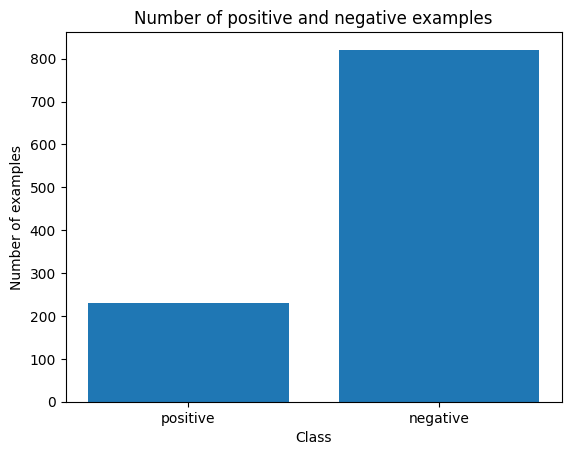

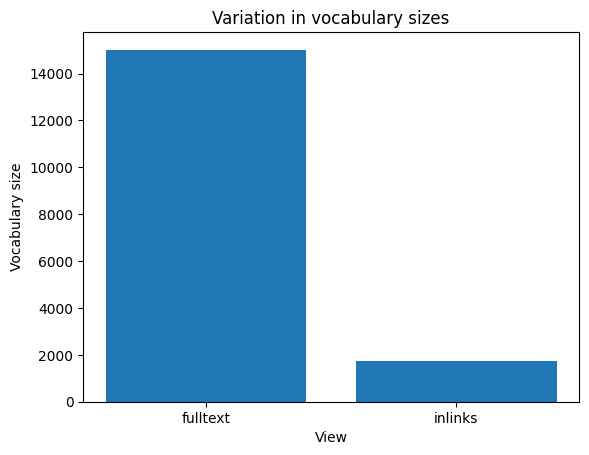

In [48]:
import matplotlib.pyplot as plt
plt.bar(['positive','negative'],[np.sum(y_fulltext),len(y_fulltext)-np.sum(y_fulltext)])
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Number of positive and negative examples')
plt.show()

plt.bar(['fulltext','inlinks'],[len(vocab_fulltext),len(vocab_inlinks)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()

In [49]:
data = {'x':[], 'y':[]}
for i in range(X_fulltext.shape[0]):
    data['x'].append({'fulltext':X_fulltext[i],'inlinks':X_inlinks[i]})
    data['y'].append(y_fulltext[i])

# train test split
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)

In [50]:
# diving X_train into L and U : L has 9 non-course(0) and 3 course(1) and U has the rest
X_train_L = []
X_train_L1 = []
X_train_U = []
y_train_L = []
y_train_L1 = []
y_train_U = []

count_0 = 0
count_1 = 0

for i in range(len(X_train)):
    if y_train[i] == 0 and count_0 < 9:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_0 += 1
    elif y_train[i] == 1 and count_1 < 3:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_1 += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])

In [64]:
# Getting the trained classifiers
clf_fulltext, clf_inlinks, accuracy_list = cotrain_binary(1,3,50,75,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test)

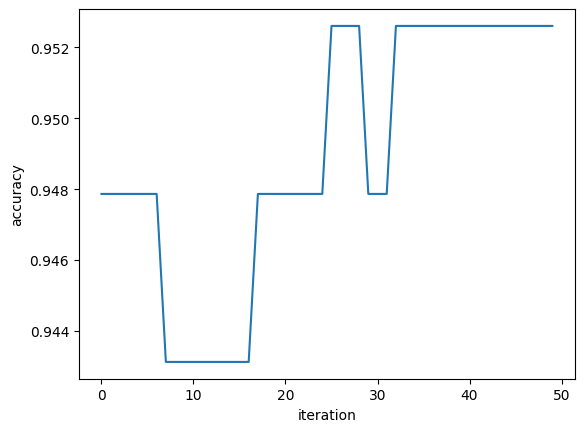

In [65]:
# plot of accuracy vs iteration
import matplotlib.pyplot as plt
plt.plot(accuracy_list)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

#### CO-TRAINING

In [66]:
acc, precision, recall, f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks, verbose=True)

print("Accuracy: ")
print(acc)
print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("f1 score: ")
print(f1)

Accuracy: 
0.95260663507109
Precision: 
0.9145509662751041
Recall: 
0.8921146953405017
f1 score: 
0.902854511970534


#### SUPERVISED LEARNING

In [67]:
# supervised training
# Intiliazing Multinomial Naive Bayes classifiers for each view
clf_fulltext_sup = MultinomialNB()
clf_inlinks_sup = MultinomialNB()

fulltext_t = []
inlinks_t = []

for i in range(len(X_train_L1)):
    fulltext_t.append(X_train_L1[i]['fulltext'])
    inlinks_t.append(X_train_L1[i]['inlinks'])

# Training the classifiers on the labeled data
clf_fulltext_sup.fit(fulltext_t, y_train_L1)
clf_inlinks_sup.fit(inlinks_t, y_train_L1)

X_test_fulltext = []
X_test_inlinks = []

for i in range(len(X_test)):
    X_test_fulltext.append(X_test[i]['fulltext'])
    X_test_inlinks.append(X_test[i]['inlinks'])

y_pred_fulltext = clf_fulltext_sup.predict_proba(X_test_fulltext)
y_pred_inlinks = clf_inlinks_sup.predict_proba(X_test_inlinks)

y_pred= []
# Calculating the accuracy
count = 0
for i in range(len(y_pred_fulltext)):
    # maximum probability from fulltext classifier
    max_prob1 = max(y_pred_fulltext[i])
    index1 = np.argmax(y_pred_fulltext[i])
    # maximum probability from inlinks classifier
    max_prob2 = max(y_pred_inlinks[i])
    index2 = np.argmax(y_pred_inlinks[i])
    # taking the maximum of the two probabilities
    if max_prob1 > max_prob2:
        y_pred.append(index1)
    else:
        y_pred.append(index2)
    if y_pred[i] == y_test[i]:
        count += 1

print("Accuracy: ")
print(count/len(y_pred_fulltext))
print("precision")
print(precision_score(y_test, y_pred, average='macro',zero_division=0))
print("recall")
print(recall_score(y_test,y_pred, average='macro',zero_division=0))
print("f1 score: ")
print(f1_score(y_test,y_pred, average='macro'))

Accuracy: 
0.8530805687203792
precision
0.4265402843601896
recall
0.5
f1 score: 
0.4603580562659847


### WEB DATA (MULTI-CLASS)

In [68]:
X_fulltext = []
Y_fulltext = []
X_inlink = []
Y_inlink = []

for filename in os.listdir('data/course-cotrain-data/fulltext/non-course'):
    for folder in os.listdir('data/webkb'):
        if folder == 'department':
            continue
        for folder1 in os.listdir('data/webkb/' + folder):
            if filename in os.listdir('data/webkb/' + folder + '/' + folder1):
                Y_fulltext.append(folder)
                X_fulltext.append(get_text('data/webkb/' + folder + '/' + folder1 + '/' + filename))
                break
            else:
                continue

for filename in os.listdir('data/course-cotrain-data/inlinks/non-course'):
    for folder in os.listdir('data/webkb'):
        if folder == 'department':
            continue
        for folder1 in os.listdir('data/webkb/' + folder):
            if filename in os.listdir('data/webkb/' + folder + '/' + folder1):
                Y_inlink.append(folder)
                X_inlink.append(get_text('data/course-cotrain-data/inlinks/non-course/'+filename))
                break
            else:
                continue

for filename in os.listdir('data/course-cotrain-data/fulltext/course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/course/'+filename))
    Y_fulltext.append('course')

for filename in os.listdir('data/course-cotrain-data/inlinks/course'):
    X_inlink.append(get_text('data/course-cotrain-data/inlinks/course/'+filename))
    Y_inlink.append('course')   

X_fulltext,vocab_fulltext = get_bag_of_words(X_fulltext)
X_inlink, vocab_inlinks = get_bag_of_words(X_inlink)

X_fulltext = X_fulltext.toarray()
X_inlink = X_inlink.toarray()

# label encoding
labelencoder = LabelEncoder()
Y_fulltext = labelencoder.fit_transform(Y_fulltext)
Y_inlink = labelencoder.fit_transform(Y_inlink)

Y_fulltext = np.array(Y_fulltext)
Y_inlink = np.array(Y_inlink)

In [69]:
data = {'x':[], 'y':[]}
for i in range(len(X_fulltext)):
    data['x'].append({'fulltext':X_fulltext[i], 'inlinks':X_inlink[i]})
    data['y'].append(Y_fulltext[i])

print(data['x'][0]['fulltext'].shape)
print(data['x'][0]['inlinks'].shape)
print(data['y'][0])

(14995,)
(1682,)
4


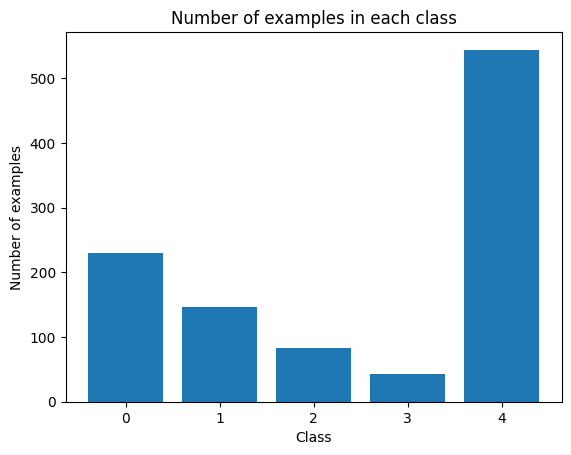

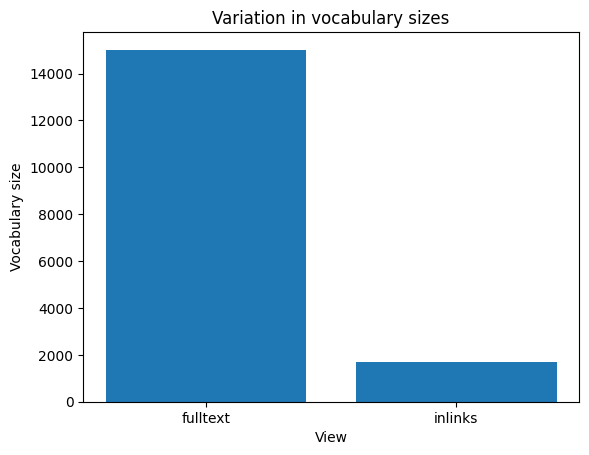

In [79]:
import matplotlib.pyplot as plt
plt.bar(['0','1','2','3','4'],[np.sum(Y_fulltext==0),np.sum(Y_fulltext==1),np.sum(Y_fulltext==2),np.sum(Y_fulltext==3),np.sum(Y_fulltext==4)])
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Number of examples in each class')
plt.show()

#plot of vocabulary size vs view
plt.bar(['fulltext','inlinks'],[len(vocab_fulltext),len(vocab_inlinks)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()


In [71]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)

In [72]:
# diving X_train into L and U : L has 5 0's, 3 1's, 2 2's, 1 3's, 12 4's
X_train_L = []
X_train_U = []
y_train_L = []
y_train_U = []
X_train_L1 = []
y_train_L1 = []

count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0

for i in range(len(X_train)):
    if y_train[i] == 0 and count_0 < 5:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_0 += 1
    elif y_train[i] == 1 and count_1 < 3:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_1 += 1
    elif y_train[i] == 2 and count_2 < 2:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_2 += 1
    elif y_train[i] == 3 and count_3 < 1:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_3 += 1
    elif y_train[i] == 4 and count_4 < 12:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_4 += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])

In [76]:
# Getting the trained classifiers
arr = [5,3,2,1,12]
clf_fulltext,clf_inlinks,acc = cotrain_multi_class(arr,50,150,X_train_L,X_train_U,y_train_L,y_train_U,X_test,y_test)

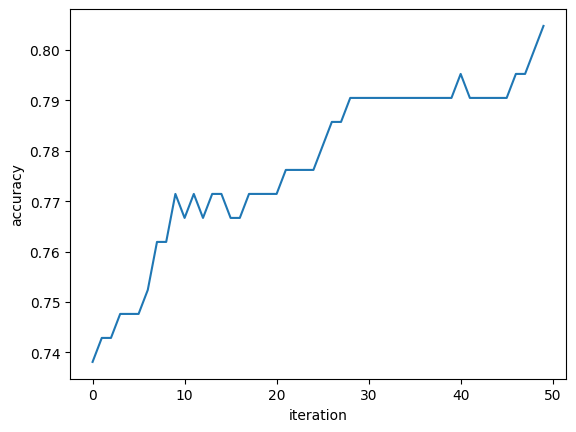

In [77]:
# plotting the accuracy vs iteration
import matplotlib.pyplot as plt
plt.plot(acc)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

### CO-TRAINING

In [78]:
# Testing the classifiers
X_test_fulltext = []
X_test_inlinks = []

for i in range(len(X_test)):
    X_test_fulltext.append(X_test[i]['fulltext'])
    X_test_inlinks.append(X_test[i]['inlinks'])

y_pred_fulltext = clf_fulltext.predict_proba(X_test_fulltext)
y_pred_inlinks = clf_inlinks.predict_proba(X_test_inlinks)

# calculating the accuracy by taking the maximum of the probabilities of the two classifiers
y_pred = []
for i in range(len(y_pred_fulltext)):
    # maximum probability from fulltext classifier
    max_prob1 = np.max(y_pred_fulltext[i])
    index1 = np.argmax(y_pred_fulltext[i])
    # maximum probability from inlinks classifier
    max_prob2 = np.max(y_pred_inlinks[i])
    index2 = np.argmax(y_pred_inlinks[i])
    if max_prob1 > max_prob2:
        y_pred.append(index1)
    else:
        y_pred.append(index2)
    
y_pred = np.array(y_pred)

# calculating the accuracy
count = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        count += 1

print('Accuracy:',count/len(y_pred))
print('Precision:',precision_score(y_test,y_pred,average='macro',zero_division=0))
print('Recall:',recall_score(y_test,y_pred,average='macro',zero_division=0))
print('f1 score:',f1_score(y_test,y_pred,average='macro',zero_division=0))

Accuracy: 0.8047619047619048
Precision: 0.6133469782250269
Recall: 0.5399275776634267
f1 score: 0.5505624268336132


### SUPERVISED LEARNING

In [80]:
# supervised training
# Intiliazing Multinomial Naive Bayes classifiers for each view
clf_fulltext_sup = MultinomialNB()
clf_inlinks_sup = MultinomialNB()

fulltext_t = []
inlinks_t = []

for i in range(len(X_train_L1)):
    fulltext_t.append(X_train_L1[i]['fulltext'])
    inlinks_t.append(X_train_L1[i]['inlinks'])

# Training the classifiers on the labeled data
clf_fulltext_sup.fit(fulltext_t, y_train_L1)
clf_inlinks_sup.fit(inlinks_t, y_train_L1)

y_pred_fulltext = clf_fulltext_sup.predict_proba(X_test_fulltext)
y_pred_inlinks = clf_inlinks_sup.predict_proba(X_test_inlinks)

# calculating the accuracy by taking the maximum of the probabilities of the two classifiers
y_pred = []
for i in range(len(y_pred_fulltext)):
    # maximum probability from fulltext classifier
    max_prob1 = np.max(y_pred_fulltext[i])
    index1 = np.argmax(y_pred_fulltext[i])
    # maximum probability from inlinks classifier
    max_prob2 = np.max(y_pred_inlinks[i])
    index2 = np.argmax(y_pred_inlinks[i])
    if max_prob1 > max_prob2:
        y_pred.append(index1)
    else:
        y_pred.append(index2)
    
y_pred = np.array(y_pred)

# calculating the accuracy
count = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        count += 1

print('Accuracy:',count/len(y_pred))
print('Precision:',precision_score(y_test,y_pred,average='macro',zero_division=0))
print('Recall:',recall_score(y_test,y_pred,average='macro',zero_division=0))
print('f1 score:',f1_score(y_test,y_pred,average='macro',zero_division=0))

Accuracy: 0.4714285714285714
Precision: 0.09428571428571428
Recall: 0.2
f1 score: 0.12815533980582522
